# Tailoring directional scattering in silicon nanodisks

The manipulation of light at the nanoscale is essential for advancing modern photonic technologies. High-index all-dielectric nanoparticles have emerged as a low-loss alternative to plasmonic structures, offering strong electric and magnetic resonances without the significant absorption losses typical of metals. A key advantage of these dielectric systems is the ability to exploit the interference between optically induced electric and magnetic modes, enabling precise control over light scattering directionality. In particular, silicon nanodisks can be engineered to achieve spectral overlap between electric and magnetic dipole resonances by adjusting their aspect ratio. This overlap leads to suppressed backscattering and enhanced forward scattering.

In this notebook, we reproduce the key results presented in `Isabelle Staude, Andrey E. Miroshnichenko, Manuel Decker, Nche T. Fofang, Sheng Liu, Edward Gonzales, Jason Dominguez, Ting Shan Luk, Dragomir N. Neshev, Igal Brener, and Yuri Kivshar, "Tailoring Directional Scattering through Magnetic and Electric Resonances in Subwavelength Silicon Nanodisks", ACS NANO, (2013).` [DOI: https://doi.org/10.1021/nn402736f](https://doi.org/10.1021/nn402736f).

We begin by performing a multipole decomposition of a single silicon nanodisk to identify its electric and magnetic resonances. By varying the aspect ratio of the structure, we highlight the potential for spectral overlap between these contributions to the extinction cross-section. Next, we simulate a periodic array of nanodisks with different aspect ratios and demonstrate that backscattering is strongly suppressed when the electric and magnetic dipole resonances are spectrally aligned.

<img src="img/cylinder.png" width="400" alt="Schematic of the experiment">

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tidy3d as td
import tidy3d.web as web

## Multipole Decomposition

First, we will sweep the disk aspect ratio and analyze the position of the electric and magnetic dipole resonance. To carry out the multipole decomposition, we will follow the methods described in [this](https://www.flexcompute.com/tidy3d/examples/notebooks/MultipoleExpansion/) example notebook. 

From the example above we will copy the function to carry out the multipole decomposition, and create a function to carry out the decomposition for a given `SimulationData` object.

In [2]:
# function for carrying out multipole decomposition
def ME(Ex, Ey, Ez, x, y, z, eps_xx, eps_yy, eps_zz, freqs, eps_medium):
    EModulus = 2 / (td.C_0 * td.EPSILON_0 * eps_medium)

    # first we create the 4-dimensional (x,y,z,f) datasets
    X, Y, Z, Freqs = np.meshgrid(x, y, z, freqs, indexing="ij")

    # defining the angular frequencies
    omega = 2 * np.pi * freqs

    # import libraries to carry out integration and Bessel functions
    from scipy.integrate import trapezoid as trapz
    from scipy.special import spherical_jn as jn

    # function for calculating the current density
    J = lambda Ei, epsilon: 1j * (2 * np.pi * Freqs) * td.EPSILON_0 * (epsilon - eps_medium) * Ei

    # function for calculating volume integral
    integrate = lambda Data: trapz(trapz(trapz(Data, x=x, axis=0), x=y, axis=0), x=z, axis=0)

    # defining the current densities
    Jx = J(Ex, eps_xx)
    Jy = J(Ey, eps_yy)
    Jz = J(Ez, eps_zz)

    # r vector
    r = np.sqrt(X**2 + Y**2 + Z**2)

    # wavevector
    k = omega / td.C_0

    # dot product k.r
    kr = k * r

    # dot product r.J
    rj = X * Jx + Y * Jy + Z * Jz

    # function for calculating dipole moments
    P = lambda Ji, Xi: (1j / omega) * (
        integrate(Ji * jn(0, kr))
        + ((k**2) / 2) * integrate((3 * rj * Xi - Ji * r**2) * jn(2, kr) / kr**2)
    )

    # dipole moments
    Px = P(Jx, X)
    Py = P(Jy, Y)
    Pz = P(Jz, Z)

    Ed = np.abs(Px) ** 2 + np.abs(Py) ** 2 + np.abs(Pz) ** 2

    # cross product for calculating magnetic moments
    rXJ_x = Y * Jz - Z * Jy
    rXJ_y = Z * Jx - X * Jz
    rXJ_z = X * Jy - Y * Jx

    # dipole magnetic moments
    Mx = (3 / 2) * integrate(rXJ_x * jn(1, kr) / kr)
    My = (3 / 2) * integrate(rXJ_y * jn(1, kr) / kr)
    Mz = (3 / 2) * integrate(rXJ_z * jn(1, kr) / kr)

    Md = np.abs(Mx) ** 2 + np.abs(My) ** 2 + np.abs(Mz) ** 2

    # auxiliary lists for calculating quadrupoles
    coords = [X, Y, Z]
    crossProd = [rXJ_x, rXJ_y, rXJ_z]
    Js = [Jx, Jy, Jz]

    # electric quadrupole
    Eq = np.zeros(Px.shape)
    for alpha in range(3):
        for beta in range(3):
            ra = coords[alpha]
            rb = coords[beta]
            ja = Js[alpha]
            jb = Js[beta]

            delta = 0 if alpha != beta else 1

            integrand1 = (3 * (ra * jb + rb * ja) - 2 * rj * delta) * (jn(1, kr) / kr)
            integrand2 = ((5 * ra * rb * rj) - (ra * jb + rb * ja) * r**2 - (r**2 * rj * delta)) * (
                jn(3, kr) / kr**3
            )

            Eq_ab = (3j / omega) * (integrate(integrand1) + (2 * k**2) * integrate(integrand2))

            Eq += (1 / 120) * np.abs(k * Eq_ab) ** 2

    # magnetic quadrupole
    Mq = np.zeros(Px.shape)
    for alpha in range(3):
        for beta in range(3):
            ra = coords[alpha]
            rb = coords[beta]

            rxja = crossProd[alpha]
            rxjb = crossProd[beta]

            Mq_ab = 15 * integrate((ra * rxjb + rb * rxja) * jn(2, kr) / kr**2)
            Mq += (1 / 120) * (np.abs(k * Mq_ab) ** 2) / td.C_0**2

    # constants
    k = (2 * np.pi * freqs) / td.C_0
    const = (k**4) / (6 * np.pi * ((eps_medium * td.EPSILON_0) ** 2) * EModulus)

    return Ed * const, Md * const / (td.C_0 / np.sqrt(eps_medium)) ** 2, Eq * const, Mq * const

We will also define an auxiliary function for calling the ME function for a given SimulationData object.

In [3]:
def run_me(sim_data):
    freqs = sim_data["fieldMon"].Ex.f.values
    eps_medium = sim_data.simulation.medium.permittivity

    # electric field and permittivity data
    E = sim_data["fieldMon"]
    Eps = sim_data["epsMon"]

    eps_xx = Eps.eps_xx
    eps_yy = Eps.eps_yy
    eps_zz = Eps.eps_zz

    Ex = E.Ex
    Ey = E.Ey
    Ez = E.Ez

    # spatial components
    x, y, z = eps_xx.x, eps_xx.y, eps_xx.z

    # calling the function.

    Ed, Md, Eq, Mq = ME(
        Ex.values,
        Ey.values,
        Ez.values,
        x.values,
        y.values,
        z.values,
        eps_xx.values,
        eps_yy.values,
        eps_zz.values,
        freqs,
        eps_medium,
    )

    return Ed, Md, Eq, Mq

## Simulation Setup

Next we will define a function for creating the `Simulation` object. The model consists in a single unit cell of a Si cylinder, with the needed monitors for calculating the multipole expansion;

In [4]:
# global variables
height = 0.22

index_disk = 3.5
index_medium = 1.5

disk_medium = td.Medium(permittivity=index_disk**2)
background_medium = td.Medium(permittivity=index_medium**2)

run_time = 5e-12

In [5]:
def get_me_sim(radius):
    # defining source and monitor frequency
    wl2 = 1.7
    wl1 = 0.8

    freq2 = td.C_0 / wl1
    freq1 = td.C_0 / wl2

    freq0 = freq1 + (freq2 - freq1) / 2
    fwidth = (freq2 - freq1) / 2
    wl = td.C_0 / freq0

    freqs = np.linspace(freq0 - fwidth, freq0 + fwidth, 101)

    # defining the cylinder structure
    geometry = td.Cylinder(radius=radius, length=height)
    disk = td.Structure(geometry=geometry, medium=disk_medium)

    # monitor and simulation size
    lx = 2 * radius
    ly = 2 * radius
    lz = height

    Lx = wl2 + lx
    Ly = Lx
    Lz = wl2 + lz

    # adding PMLs
    boundary_spec = td.BoundarySpec(x=td.Boundary.pml(), y=td.Boundary.pml(), z=td.Boundary.pml())

    # TFSF source
    source_TFSF = td.TFSF(
        center=(geometry.center[0], geometry.center[1], -wl / 16),
        size=(
            lx * 1.3,
            ly * 1.3,
            lz + wl / 8 + 0.1,
        ),
        source_time=td.GaussianPulse(freq0=freq0, fwidth=fwidth),
        direction="+",
        injection_axis=2,
    )

    # since the structure is smaller than the target wavelength,
    # a finer mesh is required to ensure accurate results
    structure_override = td.MeshOverrideStructure(
        geometry=td.Box(center=source_TFSF.center, size=source_TFSF.size),
        dl=(0.02,) * 3,
    )

    mesh_override = [structure_override]

    grid_spec = td.GridSpec.auto(min_steps_per_wvl=15, override_structures=mesh_override)

    # field monitor for calculating the fields
    field_monitor = td.FieldMonitor(
        center=geometry.center,
        fields=["Ex", "Ey", "Ez"],
        size=(lx * 1.2, ly * 1.2, lz * 1.2),
        freqs=freqs,
        name="fieldMon",
        colocate=False,
    )

    # permittivity monitor
    permittivity_monitor = td.PermittivityMonitor(
        center=field_monitor.center,
        size=field_monitor.size,
        freqs=field_monitor.freqs,
        name="epsMon",
    )

    sim_me = td.Simulation(
        size=(Lx, Ly, Lz),
        boundary_spec=boundary_spec,
        grid_spec=grid_spec,
        sources=[source_TFSF],
        monitors=[field_monitor, permittivity_monitor],
        structures=[disk],
        run_time=run_time,
        medium=background_medium,
    )

    return sim_me

Now we plot the model to make sure everything is correct.

In [6]:
sim = get_me_sim(0.5)
sim.plot_3d()

plt.show()

## Tuning the Electric and Magnetic Components

Next, we perform a parameter sweep over the disk diameter to vary the aspect ratio of the structure, aiming to identify the condition where the electric and magnetic dipole resonances spectrally overlap.

In [7]:
r_list = np.linspace(0.2, 0.6, 10) / 2
sims_me = {r: get_me_sim(r) for r in r_list}
batch_me = web.Batch(simulations=sims_me, folder_name="cylinders_me")

Run the batch.

In [8]:
batch_data_me = batch_me.run()

Output()

20:00:33 CEST Started working on Batch containing 10 tasks.

20:00:41 CEST Maximum FlexCredit cost: 0.337 for the whole batch.

              Use 'Batch.real_cost()' to get the billed FlexCredit cost after   
              the Batch has completed.

Output()

20:03:14 CEST Batch complete.

Output()

Carry out multipole decomposition for each simulation.

In [9]:
MDs = []
EDs = []

for r in r_list:
    sim_data = batch_data_me[str(r)]
    Ed, Md, Eq, Mq = run_me(sim_data)

    EDs.append(Ed)
    MDs.append(Md)

Now, we analyze the position of the resonance peak of the electric and magnetic dipole.

In [10]:
freq_ed = 1e15
freq_md = 1e15

max_ed = []
max_md = []

freqs = sim.monitors[0].freqs

for i in range(len(MDs)):
    # electric and magnetic dipole contributions
    Ed = np.array(EDs[i])
    Md = np.array(MDs[i])

    # ignore the data to the lower frequencies of the last resonance to make sure we will follow the same resonance
    Ed[freqs > freq_ed] = 0
    Md[freqs > freq_md] = 0

    idx_ed = np.argmax(Ed)
    idx_md = np.argmax(Md)

    freq_ed = freqs[idx_ed]
    freq_md = freqs[idx_md]

    max_ed.append(td.C_0 / freqs[idx_ed])
    max_md.append(td.C_0 / freqs[idx_md])

As we can see, the electric and magnetic components are at the same frequency for a disk diameter of around 0.29 µm. The results match very well the ones presented on figure 1 of the reference [paper](https://doi.org/10.1021/nn402736f).

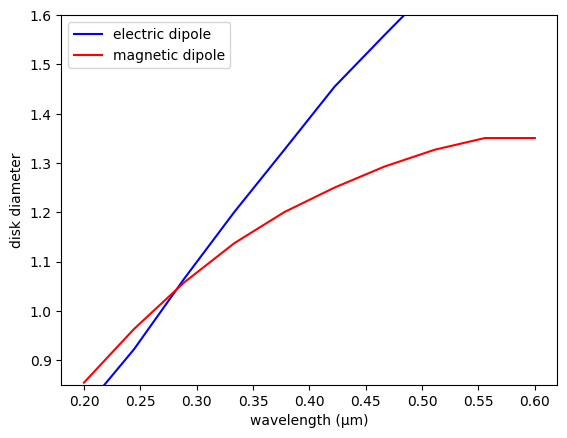

In [11]:
fig, ax = plt.subplots()
ax.plot(2 * r_list, max_ed, label="electric dipole", color="blue")
ax.plot(2 * r_list, max_md, label="magnetic dipole", color="red")
ax.set_xlabel("wavelength (µm)")
ax.set_ylabel("disk diameter")
ax.set_ylim(0.85, 1.6)
ax.legend()

plt.show()

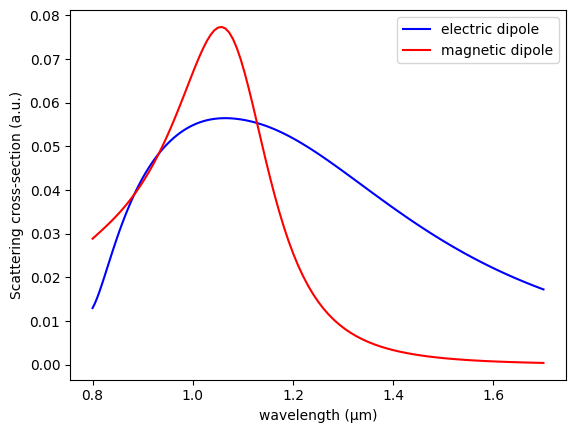

In [12]:
# electric and magnetic contributions to the diameter in which the resonances are close in frequency
idx = np.argmin(abs(r_list - 0.29 / 2))
fig, ax = plt.subplots()
ax.plot(td.C_0 / freqs, EDs[idx], label="electric dipole", color="blue")
ax.plot(td.C_0 / freqs, np.array(MDs[idx]), label="magnetic dipole", color="red")
ax.set_xlabel("wavelength (µm)")
ax.set_ylabel("Scattering cross-section (a.u.)")
ax.legend()

plt.show()

## Backscattering suppression

Now, we can simulate a periodic array of disks, and analyze the spectral transmittance and reflectance. We will define another auxiliary function to return the simulation object, now with a [FluxMonitor](https://docs.flexcompute.com/projects/tidy3d/en/latest/api/_autosummary/tidy3d.FluxMonitor.html) and [Periodic Boundary conditions](https://docs.flexcompute.com/projects/tidy3d/en/v2.7.6/faq/docs/faq/how-do-i-set-the-periodic-boundary-condition.html).

In [13]:
def get_sim(diameter, min_steps_per_wvl=15):
    # defining frequencies
    wl2 = 1.65
    wl1 = 1.25

    freq2 = td.C_0 / wl1
    freq1 = td.C_0 / wl2

    freq0 = freq1 + (freq2 - freq1) / 2
    fwidth = (freq2 - freq1) / 2
    wl = td.C_0 / freq0

    freqs = np.linspace(freq0 - fwidth, freq0 + fwidth, 101)

    source_time = td.GaussianPulse(freq0=freq0, fwidth=fwidth)

    radius = diameter / 2
    lattice_constant = 0.8

    disk = td.Structure(geometry=td.Cylinder(radius=radius, length=height), medium=disk_medium)

    sim_size = (lattice_constant, lattice_constant, height + 3 * wl)

    source = td.PlaneWave(
        source_time=source_time,
        pol_angle=0,
        angle_theta=0,
        center=(0, 0, -sim_size[2] / 2 + 1),
        direction="+",
        size=(td.inf, td.inf, 0),
    )

    # flux monitor
    flux_mon = td.FluxMonitor(
        name="flux_mon",
        size=(td.inf, td.inf, 0),
        center=(0, 0, sim_size[2] / 2 - 1),
        freqs=freqs,
    )

    # field monitor
    field_mon = td.FieldMonitor(name="field_mon", size=(0, 0, 0), center=(0, 0, 0), freqs=freqs)

    # grid spec
    grid_spec = td.GridSpec.auto(min_steps_per_wvl=min_steps_per_wvl)

    boundary_spec = td.BoundarySpec(
        x=td.Boundary.periodic(), y=td.Boundary.periodic(), z=td.Boundary.pml()
    )

    sim = td.Simulation(
        size=sim_size,
        center=(0, 0, 0),
        grid_spec=grid_spec,
        structures=[disk],
        sources=[source],
        monitors=[flux_mon, field_mon],
        run_time=run_time,
        boundary_spec=boundary_spec,
        medium=background_medium,
    )

    return sim

Sweep over multiple disk diameters

In [14]:
diameters = np.linspace(0.4, 0.6, 9)

batch = web.Batch(simulations={i: get_sim(i) for i in diameters})
batch_data = batch.run()

Output()

20:04:41 CEST Started working on Batch containing 9 tasks.

20:04:48 CEST Maximum FlexCredit cost: 0.225 for the whole batch.

              Use 'Batch.real_cost()' to get the billed FlexCredit cost after   
              the Batch has completed.

Output()

20:30:12 CEST Batch complete.

Output()

Now we analyze the transmitted flux over all simulations, and also the points of maximum for the electric and magnetic fields.

In [15]:
T = []
E_max = []
H_max = []

for d in diameters:
    sim_data = batch_data[str(d)]
    flux = sim_data["flux_mon"].flux

    # extract E field components
    Ex = sim_data["field_mon"].Ex
    Ey = sim_data["field_mon"].Ey
    Ez = sim_data["field_mon"].Ez

    # extract H field components
    Hx = sim_data["field_mon"].Hx
    Hy = sim_data["field_mon"].Hy
    Hz = sim_data["field_mon"].Hz

    # calculate |E| and |H| (magnitude)
    E = np.sqrt(np.abs(Ex) ** 2 + np.abs(Ey) ** 2 + np.abs(Ez) ** 2)
    H = np.sqrt(np.abs(Hx) ** 2 + np.abs(Hy) ** 2 + np.abs(Hz) ** 2)

    idx_e = E.argmax()
    E_max.append(float(td.C_0 / E.f[idx_e]))

    idx_m = H.argmax()
    H_max.append(float(td.C_0 / H.f[idx_m]))

    flux = flux.assign_coords(wl=td.C_0 / flux.coords["f"])
    flux = flux.swap_dims({"f": "wl"})
    flux = flux.drop_vars("f")

    T.append(flux)

T = np.array(T)

By visualizing the transmitted and reflected flux, we observe a suppression of backscattering when the magnetic and electric field resonances overlap. The results closely match figure 4 of the reference [paper](https://doi.org/10.1021/nn402736f).

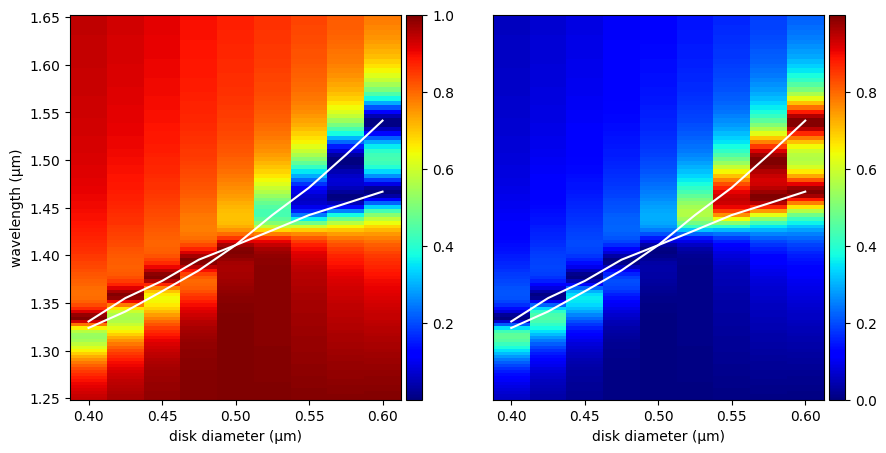

In [16]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

freqs = E.f

fig, ax = plt.subplots(ncols=2, figsize=(10, 5))
pm = ax[0].pcolormesh(diameters, td.C_0 / freqs, T.T, shading="auto", cmap="jet")
pm2 = ax[1].pcolormesh(diameters, td.C_0 / freqs, 1 - T.T, shading="auto", cmap="jet")

for axes, p in zip(ax, [pm, pm2]):
    divider = make_axes_locatable(axes)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(p, cax=cax)


for a in ax:
    x_lim = a.get_xlim()

    a.plot(diameters, E_max, color="white")
    a.plot(diameters, H_max, color="white")

    a.set_xlim(x_lim)
    a.set_xlabel("disk diameter (µm)")

ax[0].set_ylabel("wavelength (µm)")
ax[1].tick_params(left=False, labelleft=False)

plt.show()